In [20]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import  precision_score, recall_score, f1_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.model_2 import Net
from torchvision import models

In [21]:
df = pd.read_csv('data/raw/dukecathr.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
balance_accuracy_list = []
precision_list = []
recall_list = []

In [23]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data in tqdm(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        predicted = torch.round(torch.sigmoid(pred))  # Apply sigmoid and round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

In [24]:
def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.detach().cpu().numpy())  # Detach the tensor before converting to numpy
    test_loss=running_loss/len(dataloader)
    test_accu=100.*correct/total
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    return test_loss, test_accu, balance_acc, precision, recall

In [25]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=25, model_path='models/FeedForwardNet/saved_model.pth'):
    model = model.to(device)  # Move the model to the GPU
    
    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer)
        train_accu.append(accu)
        train_losses.append(train_loss)

        test_loss, test_accu, balance_acc, precision, recall = evaluate_epoch(model, test_dataloader, criterion)
        eval_losses.append(test_loss)
        eval_accu.append(test_accu)

        # Append the metrics to the lists
        balance_accuracy_list.append(balance_acc)
        precision_list.append(precision)
        recall_list.append(recall)

        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_accu:.3f} | Balance Accuracy: {balance_acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')

    # Compute the average of the metrics over all epochs
    avg_balance_acc = sum(balance_accuracy_list) / len(balance_accuracy_list)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    torch.save(model.state_dict(), model_path)
     
     

    # Store the averages in a list
    averages = [avg_balance_acc, avg_precision, avg_recall]

    return averages

In [26]:
def evaluate_model(model, dataloader, criterion):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    # Append the metrics to the lists
    balance_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

In [27]:
def process_target(df, target):
        # Step 1: Preprocess the data
    X, y, num_cols, cat_cols = output_selection_prepro(df, target)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=465)
    
    Scaler = StandardScaler( )
    X_train = Scaler.fit_transform(X_train)
    X_test = Scaler.transform(X_test)
    
    
    # Convert features and labels to tensors
    X_train_tensor = torch.tensor(X_train.astype(np.float32))
    X_test_tensor = torch.tensor(X_test.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
    y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

    # Convert the data into PyTorch tensors and load them into a DataLoader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    #save test data
    torch.save(test_data, f'data/processed/{target}/test_data.pth')

    batch_size = 2048
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

    # Define the model, loss function, and optimizer
    # Load the pre-trained model
    model = models.resnet50(pretrained=True)

    # Freeze the pre-trained layers
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)
    model = model.to(device) 
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0009)

    # Train the model
    average = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=150)
    
    
    print(f'\nAverage Balanced Accuracy: {average[0]:.3f} | Average Precision: {average[1]:.3f} | Average Recall: {average[2]:.3f}')
    evaluate_model(model, test_loader, criterion)

In [28]:
process_target(df, 'RCAST')

Loading data from data/processed/RCAST/imputed_data_RCAST.csv...
No missing values found.
Final X columns: ['RDAYSFROMINDEX', 'RSEQCATHNUM', 'RSUBJID', 'YRCATH_G', 'AGE_G', 'GENDER', 'RACE_G', 'DPCABG', 'DPMI', 'DPPCI', 'HXANGINA', 'HXCEREB', 'HXCHF', 'HXCOPD', 'HXDIAB', 'HXHTN', 'HXHYL', 'HXMI', 'HXSMOKE', 'NUMPRMI', 'DIASBP_R', 'PULSE_R', 'SYSBP_R', 'CBRUITS', 'HEIGHT_R', 'S3', 'WEIGHT_R', 'CREATININE_R', 'HDL_R', 'LDL_R', 'TOTCHOL_R', 'CATHAPPR', 'DIAGCATH', 'INTVCATH', 'CORDOM', 'GRAFTST', 'LVEF_R', 'DAYS2LKA', 'DSCABG', 'DSMI', 'DSPCI', 'DSSTROKE', 'FUPROTCL']


c:\Users\charb\.conda\envs\mlenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\charb\.conda\envs\mlenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


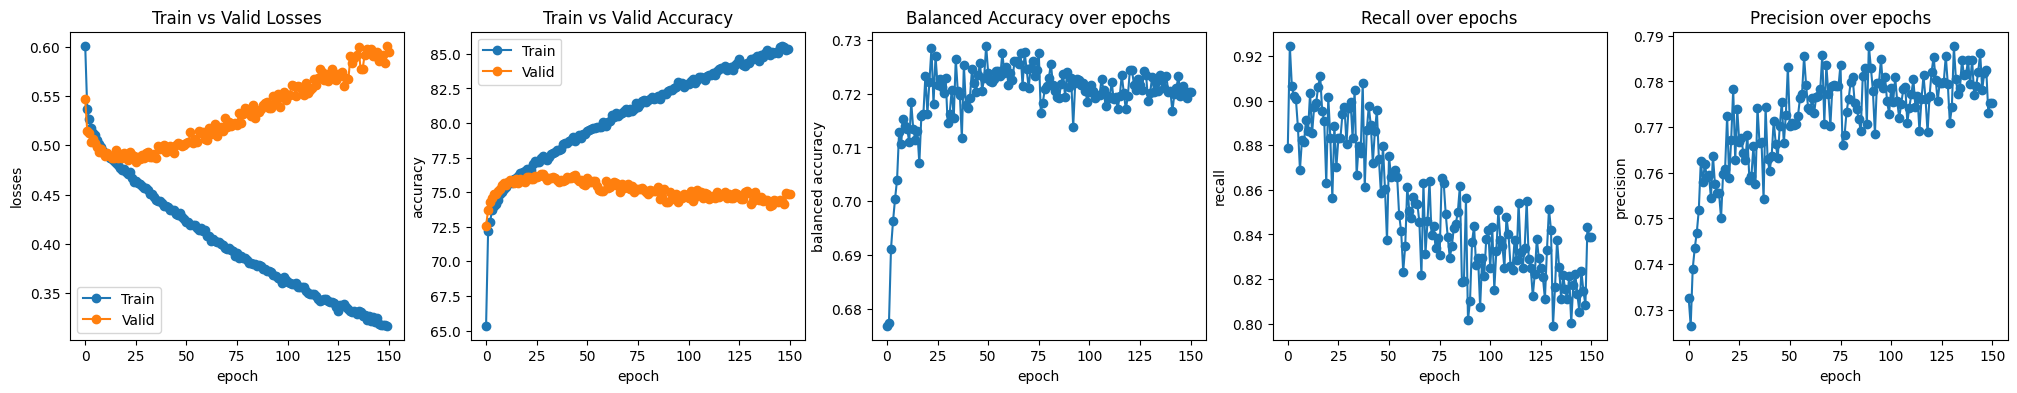

In [ ]:
# plot the loss and accuracy and
metrics = {
    'train_losses': train_losses,
    'train_accu': train_accu,
    'eval_losses': eval_losses,
    'eval_accu': eval_accu,
    'balance_accuracy_list': balance_accuracy_list,
    'precision_list': precision_list,
    'recall_list': recall_list
}
plot_metrics(metrics, ['loss', 'accuracy', 'balance_accuracy', 'recall', 'precision'])

In [ ]:
accuracy, precision, recall, balance_accuracy = test_model('models/FeedForwardNet/saved_model.pth', 'RCAST')

In [ ]:
print(f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}')

Accuracy: 0.749 | Precision: 0.775 | Recall: 0.839 | Balance Accuracy: 0.720
